In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
class ParallelCNNRNN(nn.Module):
    def __init__(self, num_classes=8):
        super(ParallelCNNRNN, self).__init__()
        
        self.nb_filters1 = 16
        self.nb_filters2 = 32
        self.nb_filters3 = 64
        self.nb_filters4 = 64
        self.nb_filters5 = 64
        self.ksize = (3, 1)
        self.pool_size_1 = (2, 2)
        self.pool_size_2 = (4, 4)
        self.pool_size_3 = (4, 2)
        self.lstm_count = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, self.nb_filters1, kernel_size=self.ksize),
            nn.ReLU(),
            nn.MaxPool2d(self.pool_size_1)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(self.nb_filters1, self.nb_filters2, kernel_size=self.ksize),
            nn.ReLU(),
            nn.MaxPool2d(self.pool_size_1)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(self.nb_filters2, self.nb_filters3, kernel_size=self.ksize),
            nn.ReLU(),
            nn.MaxPool2d(self.pool_size_1)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(self.nb_filters3, self.nb_filters4, kernel_size=self.ksize),
            nn.ReLU(),
            nn.MaxPool2d(self.pool_size_2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(self.nb_filters4, self.nb_filters5, kernel_size=self.ksize),
            nn.ReLU(),
            nn.MaxPool2d(self.pool_size_2)
        )
        
        self.cnn_flatten_dim = 256 

        self.pool_lstm = nn.MaxPool2d(self.pool_size_3)
        
        self.gru = nn.GRU(input_size=64, hidden_size=self.lstm_count, 
                          bidirectional=True, batch_first=True)

        self.fc = nn.Linear(self.cnn_flatten_dim + (self.lstm_count * 2), num_classes)

    def forward(self, x):
        c = self.conv1(x)
        c = self.conv2(c)
        c = self.conv3(c)
        c = self.conv4(c)
        c = self.conv5(c)
        
        c_flat = c.view(c.size(0), -1)
        
        r = self.pool_lstm(x)
        
        r = r.squeeze(1) 
        
        r_out, _ = self.gru(r)
        r_last = r_out[:, -1, :]
        
        combined = torch.cat((c_flat, r_last), dim=1)
        
        out = self.fc(combined)
        
        return out

In [3]:
X_train_torch = torch.randn(100, 1, 640, 128)
y_train_torch = torch.randint(0, 8, (100,))
X_valid_torch = torch.randn(20, 1, 640, 128)
y_valid_torch = torch.randint(0, 8, (20,))

BATCH_SIZE = 32
train_dataset = TensorDataset(X_train_torch, y_train_torch)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

valid_dataset = TensorDataset(X_valid_torch, y_valid_torch)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [4]:
model = ParallelCNNRNN(num_classes=8).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.0005)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=10, threshold=0.01, verbose=True
)

C:\Users\dhgml\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [5]:
EPOCHS = 50
best_acc = 0.0

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
    train_acc = correct / total
    
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, targets in valid_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += targets.size(0)
            val_correct += predicted.eq(targets).sum().item()
            
    val_acc = val_correct / val_total
    
    scheduler.step(val_acc)
    
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'weights.best.pth')
        print(f" -> Model saved! (Val Acc: {val_acc:.4f})")
        
    print(f"Train Loss: {train_loss/len(train_loader):.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss/len(valid_loader):.4f} | Val Acc: {val_acc:.4f}")
    print("-" * 60)

Epoch 1/50: 100%|██████████| 4/4 [00:01<00:00,  3.49it/s]


 -> Model saved! (Val Acc: 0.2000)
Train Loss: 2.2369 | Train Acc: 0.1200
Val Loss: 2.0798 | Val Acc: 0.2000
------------------------------------------------------------


Epoch 2/50: 100%|██████████| 4/4 [00:00<00:00, 41.02it/s]


Train Loss: 2.0863 | Train Acc: 0.1700
Val Loss: 2.2198 | Val Acc: 0.0500
------------------------------------------------------------


Epoch 3/50: 100%|██████████| 4/4 [00:00<00:00, 40.36it/s]


Train Loss: 2.0339 | Train Acc: 0.1500
Val Loss: 2.2168 | Val Acc: 0.0500
------------------------------------------------------------


Epoch 4/50: 100%|██████████| 4/4 [00:00<00:00, 41.39it/s]


Train Loss: 2.0325 | Train Acc: 0.2300
Val Loss: 2.1942 | Val Acc: 0.0500
------------------------------------------------------------


Epoch 5/50: 100%|██████████| 4/4 [00:00<00:00, 42.53it/s]


Train Loss: 2.0596 | Train Acc: 0.2100
Val Loss: 2.0921 | Val Acc: 0.1500
------------------------------------------------------------


Epoch 6/50: 100%|██████████| 4/4 [00:00<00:00, 42.08it/s]


Train Loss: 2.0127 | Train Acc: 0.2800
Val Loss: 2.0606 | Val Acc: 0.1000
------------------------------------------------------------


Epoch 7/50: 100%|██████████| 4/4 [00:00<00:00, 42.31it/s]


Train Loss: 1.9902 | Train Acc: 0.3400
Val Loss: 2.0936 | Val Acc: 0.2000
------------------------------------------------------------


Epoch 8/50: 100%|██████████| 4/4 [00:00<00:00, 41.85it/s]


Train Loss: 2.0245 | Train Acc: 0.1600
Val Loss: 2.1254 | Val Acc: 0.1500
------------------------------------------------------------


Epoch 9/50: 100%|██████████| 4/4 [00:00<00:00, 42.08it/s]


 -> Model saved! (Val Acc: 0.2500)
Train Loss: 1.9525 | Train Acc: 0.3000
Val Loss: 2.1043 | Val Acc: 0.2500
------------------------------------------------------------


Epoch 10/50: 100%|██████████| 4/4 [00:00<00:00, 40.79it/s]


Train Loss: 1.9674 | Train Acc: 0.3500
Val Loss: 2.1437 | Val Acc: 0.1500
------------------------------------------------------------


Epoch 11/50: 100%|██████████| 4/4 [00:00<00:00, 43.22it/s]


Train Loss: 1.9272 | Train Acc: 0.3000
Val Loss: 2.1427 | Val Acc: 0.2000
------------------------------------------------------------


Epoch 12/50: 100%|██████████| 4/4 [00:00<00:00, 42.31it/s]


Train Loss: 1.9442 | Train Acc: 0.3200
Val Loss: 2.1792 | Val Acc: 0.2000
------------------------------------------------------------


Epoch 13/50: 100%|██████████| 4/4 [00:00<00:00, 41.64it/s]


Train Loss: 1.9031 | Train Acc: 0.3900
Val Loss: 2.1497 | Val Acc: 0.2000
------------------------------------------------------------


Epoch 14/50: 100%|██████████| 4/4 [00:00<00:00, 41.84it/s]


Train Loss: 1.8865 | Train Acc: 0.2200
Val Loss: 2.1886 | Val Acc: 0.0500
------------------------------------------------------------


Epoch 15/50: 100%|██████████| 4/4 [00:00<00:00, 42.32it/s]


Train Loss: 1.8934 | Train Acc: 0.4800
Val Loss: 2.1923 | Val Acc: 0.0500
------------------------------------------------------------


Epoch 16/50: 100%|██████████| 4/4 [00:00<00:00, 42.17it/s]


Train Loss: 1.9025 | Train Acc: 0.4900
Val Loss: 2.1895 | Val Acc: 0.0500
------------------------------------------------------------


Epoch 17/50: 100%|██████████| 4/4 [00:00<00:00, 41.86it/s]


Train Loss: 1.8365 | Train Acc: 0.3700
Val Loss: 2.2257 | Val Acc: 0.1000
------------------------------------------------------------


Epoch 18/50: 100%|██████████| 4/4 [00:00<00:00, 42.07it/s]


Train Loss: 1.8385 | Train Acc: 0.3800
Val Loss: 2.2117 | Val Acc: 0.1500
------------------------------------------------------------


Epoch 19/50: 100%|██████████| 4/4 [00:00<00:00, 42.54it/s]


Train Loss: 1.8150 | Train Acc: 0.4600
Val Loss: 2.2578 | Val Acc: 0.0500
------------------------------------------------------------


Epoch 20/50: 100%|██████████| 4/4 [00:00<00:00, 41.36it/s]


Train Loss: 1.8294 | Train Acc: 0.4800
Val Loss: 2.1881 | Val Acc: 0.0500
------------------------------------------------------------


Epoch 21/50: 100%|██████████| 4/4 [00:00<00:00, 42.51it/s]


Train Loss: 1.8174 | Train Acc: 0.5300
Val Loss: 2.1508 | Val Acc: 0.1000
------------------------------------------------------------


Epoch 22/50: 100%|██████████| 4/4 [00:00<00:00, 41.15it/s]


Train Loss: 1.7554 | Train Acc: 0.5500
Val Loss: 2.1634 | Val Acc: 0.1000
------------------------------------------------------------


Epoch 23/50: 100%|██████████| 4/4 [00:00<00:00, 41.64it/s]


Train Loss: 1.7441 | Train Acc: 0.5600
Val Loss: 2.1518 | Val Acc: 0.2000
------------------------------------------------------------


Epoch 24/50: 100%|██████████| 4/4 [00:00<00:00, 41.55it/s]


Train Loss: 1.7620 | Train Acc: 0.5400
Val Loss: 2.1755 | Val Acc: 0.1000
------------------------------------------------------------


Epoch 25/50: 100%|██████████| 4/4 [00:00<00:00, 41.40it/s]


Train Loss: 1.7284 | Train Acc: 0.4400
Val Loss: 2.1819 | Val Acc: 0.1500
------------------------------------------------------------


Epoch 26/50: 100%|██████████| 4/4 [00:00<00:00, 42.31it/s]


Train Loss: 1.7403 | Train Acc: 0.5500
Val Loss: 2.1911 | Val Acc: 0.0000
------------------------------------------------------------


Epoch 27/50: 100%|██████████| 4/4 [00:00<00:00, 41.01it/s]


Train Loss: 1.7402 | Train Acc: 0.6100
Val Loss: 2.1807 | Val Acc: 0.1500
------------------------------------------------------------


Epoch 28/50: 100%|██████████| 4/4 [00:00<00:00, 42.09it/s]


Train Loss: 1.7340 | Train Acc: 0.5100
Val Loss: 2.1838 | Val Acc: 0.1000
------------------------------------------------------------


Epoch 29/50: 100%|██████████| 4/4 [00:00<00:00, 42.53it/s]


Train Loss: 1.7168 | Train Acc: 0.5200
Val Loss: 2.2089 | Val Acc: 0.1500
------------------------------------------------------------


Epoch 30/50: 100%|██████████| 4/4 [00:00<00:00, 41.33it/s]


Train Loss: 1.6528 | Train Acc: 0.5600
Val Loss: 2.1928 | Val Acc: 0.1500
------------------------------------------------------------


Epoch 31/50: 100%|██████████| 4/4 [00:00<00:00, 42.54it/s]


Train Loss: 1.7219 | Train Acc: 0.5500
Val Loss: 2.1844 | Val Acc: 0.2000
------------------------------------------------------------


Epoch 32/50: 100%|██████████| 4/4 [00:00<00:00, 41.20it/s]


Train Loss: 1.6622 | Train Acc: 0.6200
Val Loss: 2.1922 | Val Acc: 0.1000
------------------------------------------------------------


Epoch 33/50: 100%|██████████| 4/4 [00:00<00:00, 43.38it/s]


Train Loss: 1.7060 | Train Acc: 0.6300
Val Loss: 2.1806 | Val Acc: 0.2000
------------------------------------------------------------


Epoch 34/50: 100%|██████████| 4/4 [00:00<00:00, 42.86it/s]


Train Loss: 1.6749 | Train Acc: 0.6400
Val Loss: 2.2015 | Val Acc: 0.1000
------------------------------------------------------------


Epoch 35/50: 100%|██████████| 4/4 [00:00<00:00, 42.32it/s]


Train Loss: 1.6897 | Train Acc: 0.6200
Val Loss: 2.1949 | Val Acc: 0.0500
------------------------------------------------------------


Epoch 36/50: 100%|██████████| 4/4 [00:00<00:00, 41.90it/s]


Train Loss: 1.6868 | Train Acc: 0.6400
Val Loss: 2.1665 | Val Acc: 0.2000
------------------------------------------------------------


Epoch 37/50: 100%|██████████| 4/4 [00:00<00:00, 42.08it/s]


Train Loss: 1.6687 | Train Acc: 0.6200
Val Loss: 2.1751 | Val Acc: 0.0500
------------------------------------------------------------


Epoch 38/50: 100%|██████████| 4/4 [00:00<00:00, 42.53it/s]


Train Loss: 1.6299 | Train Acc: 0.6100
Val Loss: 2.1938 | Val Acc: 0.0500
------------------------------------------------------------


Epoch 39/50: 100%|██████████| 4/4 [00:00<00:00, 42.99it/s]


Train Loss: 1.6401 | Train Acc: 0.6100
Val Loss: 2.2034 | Val Acc: 0.0500
------------------------------------------------------------


Epoch 40/50: 100%|██████████| 4/4 [00:00<00:00, 42.53it/s]


Train Loss: 1.6565 | Train Acc: 0.6400
Val Loss: 2.2029 | Val Acc: 0.0500
------------------------------------------------------------


Epoch 41/50: 100%|██████████| 4/4 [00:00<00:00, 42.22it/s]


Train Loss: 1.6755 | Train Acc: 0.6200
Val Loss: 2.2025 | Val Acc: 0.0500
------------------------------------------------------------


Epoch 42/50: 100%|██████████| 4/4 [00:00<00:00, 41.17it/s]


Train Loss: 1.5992 | Train Acc: 0.6500
Val Loss: 2.1970 | Val Acc: 0.1500
------------------------------------------------------------


Epoch 43/50: 100%|██████████| 4/4 [00:00<00:00, 42.97it/s]


Train Loss: 1.6768 | Train Acc: 0.6400
Val Loss: 2.1848 | Val Acc: 0.1500
------------------------------------------------------------


Epoch 44/50: 100%|██████████| 4/4 [00:00<00:00, 41.21it/s]


Train Loss: 1.6508 | Train Acc: 0.6300
Val Loss: 2.1839 | Val Acc: 0.1500
------------------------------------------------------------


Epoch 45/50: 100%|██████████| 4/4 [00:00<00:00, 42.09it/s]


Train Loss: 1.6075 | Train Acc: 0.6400
Val Loss: 2.1925 | Val Acc: 0.1500
------------------------------------------------------------


Epoch 46/50: 100%|██████████| 4/4 [00:00<00:00, 41.16it/s]


Train Loss: 1.6020 | Train Acc: 0.6700
Val Loss: 2.1906 | Val Acc: 0.1500
------------------------------------------------------------


Epoch 47/50: 100%|██████████| 4/4 [00:00<00:00, 41.63it/s]


Train Loss: 1.5793 | Train Acc: 0.6300
Val Loss: 2.1912 | Val Acc: 0.1500
------------------------------------------------------------


Epoch 48/50: 100%|██████████| 4/4 [00:00<00:00, 42.31it/s]


Train Loss: 1.6342 | Train Acc: 0.6400
Val Loss: 2.1940 | Val Acc: 0.1500
------------------------------------------------------------


Epoch 49/50: 100%|██████████| 4/4 [00:00<00:00, 42.49it/s]


Train Loss: 1.5833 | Train Acc: 0.6100
Val Loss: 2.1990 | Val Acc: 0.1500
------------------------------------------------------------


Epoch 50/50: 100%|██████████| 4/4 [00:00<00:00, 41.18it/s]

Train Loss: 1.5811 | Train Acc: 0.6400
Val Loss: 2.1941 | Val Acc: 0.1500
------------------------------------------------------------


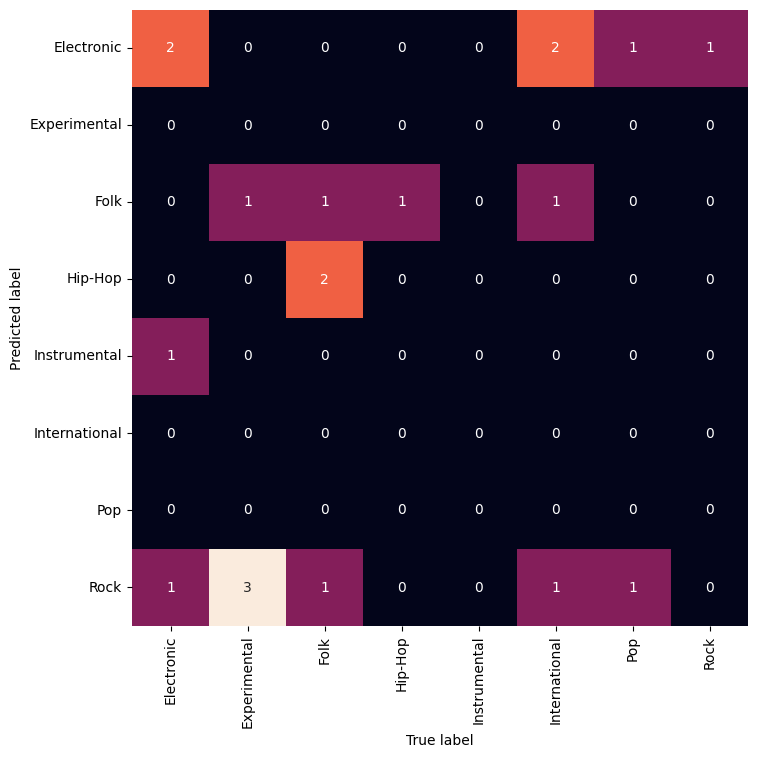

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

target_names = ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 
                'Instrumental', 'International', 'Pop', 'Rock']
mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_names,
            yticklabels=target_names)

plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.show()